In this kernel, we will explore the complete workflow for the APTOS 2019 competition. We will go through:

1. Loading & Exploration: A quick overview of the dataset
2. Resize Images: We will resize both the training and test images to 224x224, so that it matches the ImageNet format.
3. Mixup & Data Generator: We show how to create a data generator that will perform random transformation to our datasets (flip vertically/horizontally, rotation, zooming). This will help our model generalize better to the data, since it is fairly small (only ~3000 images).
4. Quadratic Weighted Kappa: A thorough overview of the metric used for this competition, with an intuitive example. Check it out!
5. Model: We will use a DenseNet-121 pre-trained on ImageNet. We will finetune it using Adam for 15 epochs, and evaluate it on an unseen validation set.
6. Training & Evaluation: We take a look at the change in loss and QWK score through the epochs.

### Citations & Resources

* I had the idea of using mixup from [KeepLearning's ResNet50 baseline](https://www.kaggle.com/mathormad/aptos-resnet50-baseline). Since the implementation was in PyTorch, I instead used an [open-sourced keras implementation](https://github.com/yu4u/mixup-generator).
* The transfer learning procedure is mostly inspired from my [previous kernel for iWildCam](https://www.kaggle.com/xhlulu/densenet-transfer-learning-iwildcam-2019). The workflow was however heavily modified since then.
* Used similar [method as Abhishek](https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa) to find the optimal threshold.
* [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets) prompted me to try using Multilabel instead of multiclass classification, which slightly improved the kappa score.

In [11]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

from keras import layers
from keras.applications import *
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import scipy
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

# Loading & Exploration

In [6]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
train_meta = pd.read_csv('../data/train_meta.csv')
test_meta = pd.read_csv('../data/test_meta.csv')
print(train_df.shape)
print(test_df.shape)
print(train_meta.shape, test_meta.shape)

(3662, 2)
(1928, 1)
(3662, 8) (1928, 7)


In [7]:
train_meta.head()

,id_code,diagnosis,image_shape,image_size,height,width,width_height_ratio,width_height_added
0,000c1434d8d7,2,"(2136, 3216, 3)",3218676,2136,3216,0.664179,5352
1,001639a390f0,4,"(2136, 3216, 3)",2261129,2136,3216,0.664179,5352
2,0024cdab0c1e,1,"(1736, 2416, 3)",1882172,1736,2416,0.718543,4152
3,002c21358ce6,0,"(1050, 1050, 3)",975218,1050,1050,1.000000,2100
4,005b95c28852,0,"(1536, 2048, 3)",1819430,1536,2048,0.750000,3584


In [9]:
m_train = train_meta[['image_size', 'height', 'width', 'width_height_ratio', 'width_height_added']].values
m_test = test_meta[['image_size', 'height', 'width', 'width_height_ratio', 'width_height_added']].values

In [12]:
SS = StandardScaler()
SS.fit(m_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
m_train = SS.transform(m_train)
m_test = SS.transform(m_test)

In [4]:
def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    return im

In [5]:
def load_ben_color(path, size, crop=False, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if crop:
        image = crop_image_from_gray(image)
    image = cv2.resize(image, (size, size))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

def load_ben_gray(path, size):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (size, size))
    image = cv2.addWeighted(
       image, 4, cv2.GaussianBlur(image, (0, 0), size / 10), -4, 128
    )  # Ben Graham's preprocessing method [1]
    ## (IMG_SIZE, IMG_SIZE) -> (IMG_SIZE, IMG_SIZE, 3)
    image = image.reshape(size, size, 1)
    image = np.repeat(image, 3, axis=-1)
    return image

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [5]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = np.load(
        f'../data/train_images/npy_bengrahm/{image_id}.npy'
    )

100%|██████████| 3662/3662 [00:00<00:00, 3770.21it/s]


In [6]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = load_ben_gray(
        f'../data/test_images/{image_id}.png', 224
    )

100%|██████████| 1928/1928 [00:52<00:00, 36.40it/s]


In [7]:
#!mkdir ../data/npy_files
#np.save('../data/npy_files/x_train.npy', x_train)

In [8]:
#x_train = np.load('../data/npy_files/x_train.npy')
#x_test = np.load('../data/npy_files/x_test.npy')

In [9]:
y_train = pd.get_dummies(train_df['diagnosis']).values
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


## Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [10]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [11]:
x_train.shape, y_train_multi.shape

((3662, 224, 224, 3), (3662, 5))

In [12]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.15, 
    random_state=2019
)

# Mixup & Data Generator

In [13]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [14]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE)
# Using Mixup
mixup_generator = MixupGenerator(x_train, y_train, batch_size=BATCH_SIZE, alpha=0.2, datagen=create_datagen())()

### Creating keras callback for QWK

In [15]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5 # <<<<<<<<<<<<<<<<<<<
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Model: DenseNet-121

In [16]:
xception = Xception(
    include_top=False,
   input_shape=(224, 224, 3)
) 

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
# densenet = DenseNet121(
#     include_top=False,
#     input_shape=(224,224,3)
# )

In [ ]:
# First define the image model
image_processor = Sequential()
image_processor.add(DenseNet121)
model.add(layers.GlobalAveragePooling2D())
image_processor.add(Flatten())
model.add(layers.Dropout(0.5))


# Now we create the metadata model
metadata_processor = Sequential()
metadata_processor.add(Dense(10, input_dim=metadata_dim))
metadata_processor.add(Activation('relu'))
metadata_processor.add(Dense(10))
metadata_processor.add(Activation('relu'))

# Now we concatenate the two features and add a few more layers on top
model = Sequential()
model.add(Merge([image_processor, metadata_processor], merge_mode='concat')  # Merge is your sensor fusion buddy
model.add(Dense(5, input_dim=image_plus_metadata_dim, activation="sigmoid"))

In [18]:
def build_model():
    model = Sequential()
    #model.add(densenet)
    model.add(xception)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [19]:
#del model

In [20]:
model = build_model()
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


# Training & Evaluation

In [50]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)

Epoch 1/10
98/97 [==============================] - 41s 417ms/step - loss: 0.0788 - acc: 0.9695 - val_loss: 0.1517 - val_acc: 0.9527
val_kappa: 0.8636
Validation Kappa has improved. Saving model.
Epoch 2/10
98/97 [==============================] - 41s 418ms/step - loss: 0.0728 - acc: 0.9714 - val_loss: 0.1482 - val_acc: 0.9484
val_kappa: 0.8646
Validation Kappa has improved. Saving model.
Epoch 3/10
98/97 [==============================] - 41s 419ms/step - loss: 0.0617 - acc: 0.9768 - val_loss: 0.1702 - val_acc: 0.9476
val_kappa: 0.8507
Epoch 4/10
98/97 [==============================] - 41s 420ms/step - loss: 0.0651 - acc: 0.9755 - val_loss: 0.1462 - val_acc: 0.9440
val_kappa: 0.8577
Epoch 5/10
98/97 [==============================] - 41s 420ms/step - loss: 0.0587 - acc: 0.9795 - val_loss: 0.1636 - val_acc: 0.9473
val_kappa: 0.8619
Epoch 6/10
98/97 [==============================] - 41s 421ms/step - loss: 0.0517 - acc: 0.9800 - val_loss: 0.1628 - val_acc: 0.9451
val_kappa: 0.8604
Epoc

In [22]:
with open('xception_history.json', 'w') as f:
    json.dump(history.history, f)

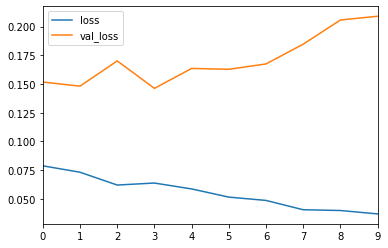

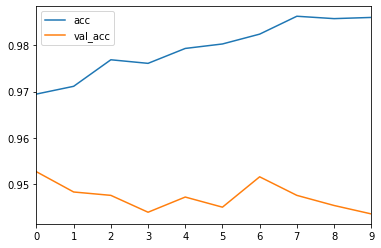

In [51]:

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

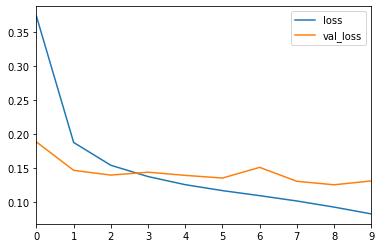

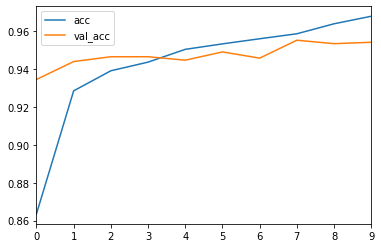

In [30]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

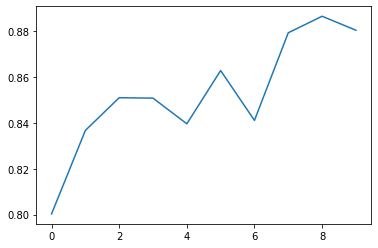

In [31]:
plt.plot(kappa_metrics.val_kappas)

# LOAD test set with  bengrahm preprocessing ffs, before final prediction 

In [32]:
#model.load_weights('model_bengrahm.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]
best_threshold

0.475

In [33]:
#best_threshold = 0.45
best_threshold

0.475

## Submit

In [49]:
for th in [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]: 
    y_test = model.predict(x_test) > th
    y_test = y_test.astype(int).sum(axis=1) - 1
    print(th, np.unique(y_test, return_counts=True))
# test_df['diagnosis'] = y_test
# test_df.to_csv('submission.csv',index=False)


0.25 (array([0, 1, 2, 3, 4]), array([ 289,  123, 1012,  411,   93]))
0.3 (array([0, 1, 2, 3, 4]), array([ 307,  127, 1032,  392,   70]))
0.35 (array([0, 1, 2, 3, 4]), array([ 323,  133, 1053,  362,   57]))
0.4 (array([0, 1, 2, 3, 4]), array([ 339,  145, 1079,  316,   49]))
0.45 (array([0, 1, 2, 3, 4]), array([ 351,  152, 1090,  294,   41]))
0.5 (array([0, 1, 2, 3, 4]), array([ 363,  153, 1117,  260,   35]))
0.55 (array([0, 1, 2, 3, 4]), array([ 373,  161, 1126,  240,   28]))


In [43]:
np.unique(y_test, return_counts=True)

(array([-1]), array([1928]))

In [39]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 307,  127, 1032,  392,   70]))